In [87]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Exploration du Dataset Airbnb

In [88]:
# Charger le dataset
df = pd.read_csv('Airbnb_preprocessed.csv')

# Afficher les informations sur le dataset
print("Shape du dataset:", df.shape)
print("\nPremières lignes:")
print(df.head())
print("\nTypes de colonnes:")
print(df.dtypes)
print("\nStatistiques descriptives:")
print(df.describe())
print("\nColonnes:")
print(df.columns.tolist())

df["price"] = np.log1p(df["price"])

Shape du dataset: (66962, 131)

Premières lignes:
   accommodates  bathrooms  bed_type  cancellation_policy  neighbourhood  \
0      0.133333      0.125         1                 0.50            0.6   
1      0.400000      0.125         1                 0.50            0.6   
2      0.266667      0.125         1                 0.00            0.3   
3      0.200000      0.125         1                 0.25            0.8   
4      0.066667      0.125         1                 0.00            0.6   

   bedrooms      beds  price  Bed & Breakfast   Boat  ...  Hair dryer  \
0  0.000000  0.055556  150.0            False  False  ...           1   
1  0.222222  0.166667  169.0            False  False  ...           1   
2  0.000000  0.166667  145.0            False  False  ...           1   
3  0.111111  0.111111  750.0            False  False  ...           0   
4  0.000000  0.055556  115.0            False  False  ...           0   

   Fire extinguisher  Wide hallway clearance  Self Che

<Axes: >

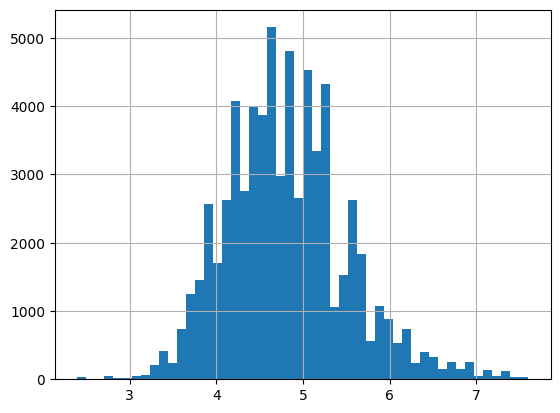

In [89]:
df.price.hist(bins=50)

# 2. Préparation des données pour l'apprentissage

## 2.1 Normalisation avec StandardScaler

Utiliser un model StandardScaler() pour normaliser les colonnes exceptée les booléennes. 
**Pourquoi réaliser cette opération ?**

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Identifier les colonnes booléennes (celles avec seulement 0 et 1)
boolean_columns = df.columns[(df.dtypes != 'object') & (df.isin([0, 1, 0.0, 1.0, True, False]).all())].tolist()
# Corriger: identifier les colonnes booléennes basées sur les valeurs
boolean_columns = [col for col in df.columns if col not in ['price'] and set(df[col].unique()).issubset({0, 1, 0.0, 1.0})]

print("Colonnes booléennes identifiées:", boolean_columns[:10], "... ({} total)".format(len(boolean_columns)))

# Colonnes à normaliser (toutes sauf les booléennes et le prix)
columns_to_normalize = [col for col in df.columns if col not in boolean_columns and col != 'price']
print("Colonnes à normaliser:", columns_to_normalize)

# Créer une copie du dataframe
df_processed = df.copy()

# Appliquer StandardScaler uniquement aux colonnes non-booléennes
scaler = StandardScaler()
df_processed[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print("\nAprès normalisation:")
print(df_processed[columns_to_normalize].describe())

print("\n** Pourquoi normaliser ? **")
print("- Ramène les features à la même échelle (moyenne=0, std=1)")
print("- Les réseaux de neurones convergent plus rapidement avec des données normalisées")
print("- Les poids initiaux sont plus appropriés pour les features normalisées")
print("- Évite que les features à grande valeur dominent l'apprentissage")
print("- Les booléennes (0,1) n'ont pas besoin de normalisation car elles sont déjà à l'échelle correcte")

Colonnes booléennes identifiées: ['bed_type', 'Bed & Breakfast', 'Boat', 'Boutique hotel', 'Bungalow', 'Cabin', 'Camper/RV', 'Condominium', 'Dorm', 'Guest suite'] ... (124 total)
Colonnes à normaliser: ['accommodates', 'bathrooms', 'cancellation_policy', 'neighbourhood', 'bedrooms', 'beds']

Après normalisation:
       accommodates     bathrooms  cancellation_policy  neighbourhood  \
count  6.696200e+04  6.696200e+04         6.696200e+04   6.696200e+04   
mean   5.114566e-17  1.055808e-16        -3.162118e-17   1.108863e-16   
std    1.000007e+00  1.000007e+00         1.000007e+00   1.000007e+00   
min   -1.007586e+00 -2.162748e+00        -1.446899e+00  -2.102091e+00   
25%   -5.352231e-01 -3.996370e-01        -1.446899e+00  -7.830164e-01   
50%   -5.352231e-01 -3.996370e-01        -2.257492e-01  -3.433248e-01   
75%    4.095032e-01 -3.996370e-01         9.954010e-01   9.757500e-01   
max    6.077861e+00  1.194214e+01         3.437701e+00   2.294825e+00   

           bedrooms         

## 2.2 Découpage train/test et réindexation

Découper le dataframe en jeu de train et jeu de test (sans séparer X et y dans un premier temps).
Utiliser reset_index() pour réindexer le train et le test.

In [91]:
# Découper en train et test (80/20)
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=42)

print("Taille avant reset_index:")
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

# Réindexer pour que les index se suivent
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("\nTaille après reset_index:")
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

print("\nIndex du train:")
print("Premiers index:", df_train.index[:5].tolist())
print("Derniers index:", df_train.index[-5:].tolist())

print("\n** Pourquoi reset_index ? **")
print("- Les index consécutifs (0, 1, 2, ...) facilitent certaines opérations")
print("- Évite les problèmes avec les index dupliqués ou non-séquentiels après le split")
print("- Améliore la gestion mémoire dans certains cas")

Taille avant reset_index:
Train shape: (53569, 131)
Test shape: (13393, 131)

Taille après reset_index:
Train shape: (53569, 131)
Test shape: (13393, 131)

Index du train:
Premiers index: [0, 1, 2, 3, 4]
Derniers index: [53564, 53565, 53566, 53567, 53568]

** Pourquoi reset_index ? **
- Les index consécutifs (0, 1, 2, ...) facilitent certaines opérations
- Évite les problèmes avec les index dupliqués ou non-séquentiels après le split
- Améliore la gestion mémoire dans certains cas


## 2.3 Oversampling

Quelle est la taille du jeu de train ? 
Augmenter le jeu de données en dupliquant quatre fois le jeu de train d'origine avec concat().

In [92]:
#on a assez de data donc pas besoin d'oversampler.

## 2.4 Création des ensembles X et y

À partir du nouveau jeu de train augmenté et du test, créer X_train, X_test, y_train, y_test.

In [93]:
# Séparer les features (X) et la cible (y)
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_test = df_test.drop('price', axis=1)
y_test = df_test['price']

print("Ensemble d'entraînement:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nEnsemble de test:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("\nStatistiques de y_train:")
print(y_train.describe())

print("\nNombre de features:", X_train.shape[1])

Ensemble d'entraînement:
X_train shape: (53569, 130)
y_train shape: (53569,)

Ensemble de test:
X_test shape: (13393, 130)
y_test shape: (13393,)

Statistiques de y_train:
count    53569.000000
mean         4.807736
std          0.702984
min          2.397895
25%          4.330733
50%          4.753590
75%          5.236442
max          7.600902
Name: price, dtype: float64

Nombre de features: 130


# 3. Modèle MLP - Régression

## 3.1 Architecture du modèle

Créer un premier modèle séquentiel avec:
- Une couche Input avec shape (N,) où N est le nombre de features
- Deux couches Dense cachées de 32 et 64 neurones
- Une couche de sortie pour la régression

Combien doit-il y avoir de neurones en sortie ?

In [94]:
# Créer le modèle séquentiel
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Sortie: 1 neurone pour la régression (prédire le prix)
])

print("** Nombre de neurones en sortie: 1 **")
print("Raison: C'est une tâche de régression avec une seule valeur à prédire (le prix)")
print("Pas besoin de fonction d'activation en sortie (None par défaut)")
print("Cela laisse la sortie en valeur continue réelle")

# Afficher le résumé du modèle
print("\n" + "="*50)
print("Résumé du modèle:")
print("="*50)
model.summary()

** Nombre de neurones en sortie: 1 **
Raison: C'est une tâche de régression avec une seule valeur à prédire (le prix)
Pas besoin de fonction d'activation en sortie (None par défaut)
Cela laisse la sortie en valeur continue réelle

Résumé du modèle:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,369 (24.88 KB)

 Trainable params: 6,369 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Explication des paramètres

Comment sont calculés les paramètres dans le modèle ?


Paramètres = (nombre d'entrées × nombre de neurones) + nombre de neurones
            = (inputs × neurons) + biases

Couche 1 (Input(130) -> Dense(32)):
  Paramètres = (130 × 32) + 32 = 4192

Couche 2 (Dense(32) -> Dense(64)):
  Paramètres = (32 × 64) + 64 = 2112

Couche 3 (Dense(64) -> Dense(1)):
  Paramètres = (64 × 1) + 1 = 65

Total des paramètres = 4192 + 2112 + 65 = 6369

Note: Cela correspond au 'Total params' affiché par model.summary()

## 3.3 Compilation du modèle

Définir les paramètres du modèle (optimizer, loss et metrics).
Pourquoi utiliser MSE pour la loss et RMSE pour les metrics ?

In [95]:
# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

**Pourquoi MSE pour la loss ?**
- **MSE (Mean Squared Error) = moyenne des carrés des erreurs**
- **Pénalise les grandes erreurs (carré des erreurs)**
- **Standard pour la régression**
- **Différentiable, permet l'optimisation par gradient**

**Pourquoi RMSE pour les metrics ?**
- **RMSE = √MSE (Racine de MSE)**
- **Plus lisible: dans les mêmes unités que la cible (prix en dollars)**
- **Permet d'interpréter l'erreur moyenne en termes directs**
- **Exemple: RMSE=50 signifie erreur moyenne de ±50 dollars**

**Optimizer = 'adam' ?**
- **Adam est un optimiseur adaptatif qui ajuste le learning rate**
- **Converige généralement plus vite que SGD**
- **Combine les avantages de l'inertie (momentum) et du RMSprop**

## 3.4 Entraînement du modèle

Entraîner le modèle sur 200 epochs avec des batchs de 256 (là 2048) et un validation_split de 20%.

In [96]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=3000,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.5640 - root_mean_squared_error: 4.3086 - val_loss: 12.3595 - val_root_mean_squared_error: 3.5156
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3521 - root_mean_squared_error: 2.7115 - val_loss: 2.4837 - val_root_mean_squared_error: 1.5760
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1279 - root_mean_squared_error: 1.4587 - val_loss: 1.9654 - val_root_mean_squared_error: 1.4019
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5134 - root_mean_squared_error: 1.2302 - val_loss: 1.3676 - val_root_mean_squared_error: 1.1694
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1705 - root_mean_squared_error: 1.0819 - val_loss: 1.0423 - val_root_mean_squared_error: 1.0210
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9124 - root_mean_squared_error: 0.9552 - val_loss: 0.8011 - val_root_mean_squared_error: 0.8951
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

## 3.5 Affichage des courbes d'apprentissage

Afficher les courbes loss, val_loss, root_mean_squared_error et val_root_mean_squared_error.
Commenter les résultats.

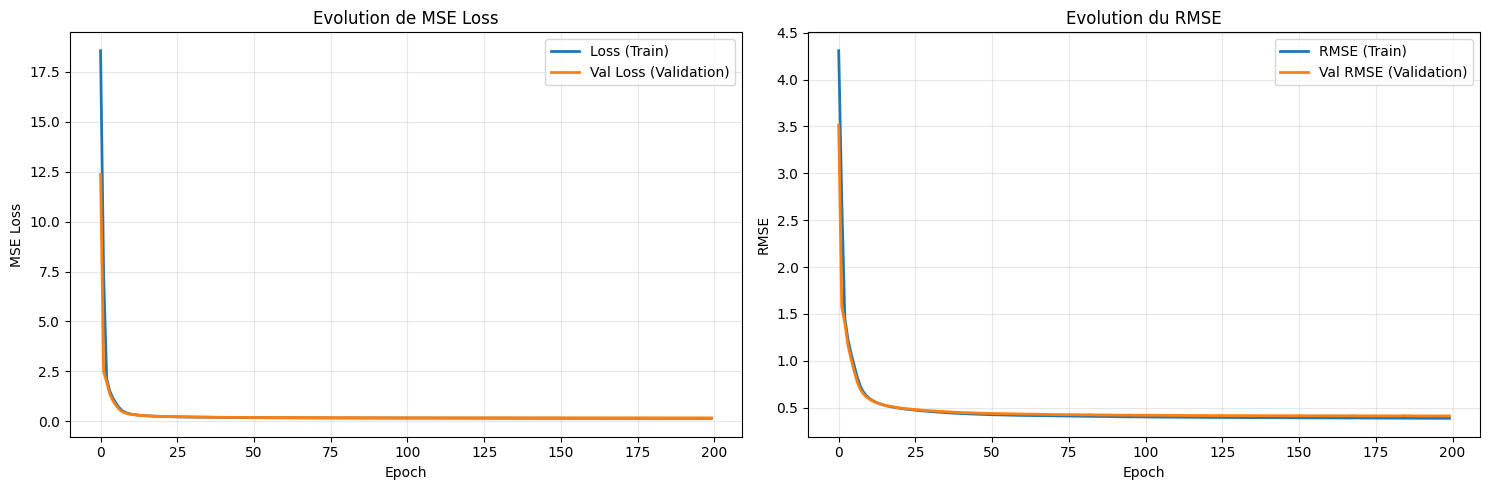

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbes de loss
axes[0].plot(history.history['loss'], label='Loss (Train)', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss (Validation)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Evolution de MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Courbes de RMSE
axes[1].plot(history.history['root_mean_squared_error'], label='RMSE (Train)', linewidth=2)
axes[1].plot(history.history['val_root_mean_squared_error'], label='Val RMSE (Validation)', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Evolution du RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.6 Prédictions et visualisation

Calculer les prédictions et afficher via un scatterplot le lien entre les valeurs de test et les prédictions.
Commenter les résultats.

419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


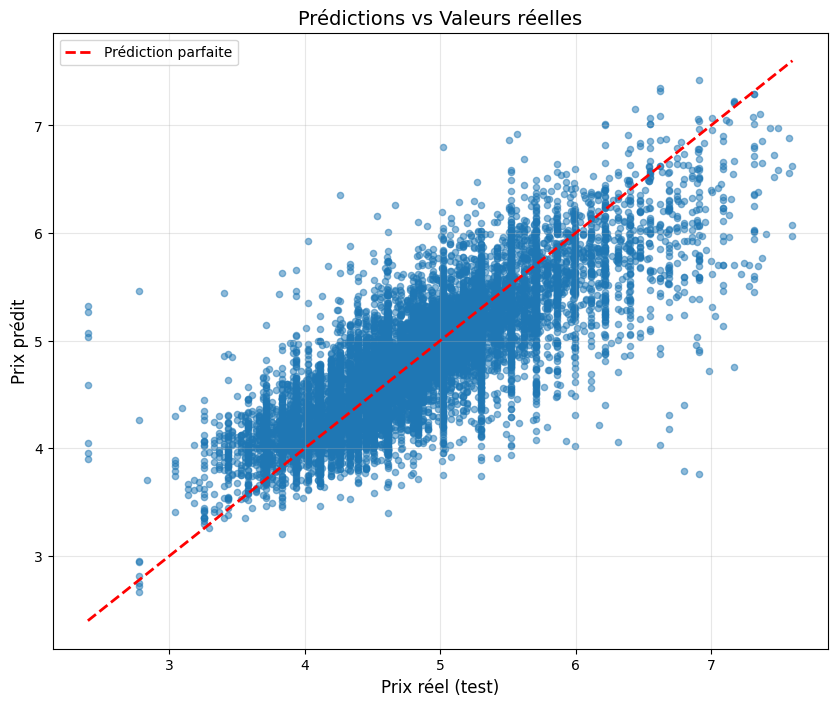


** Métriques de performance sur le jeu de test **
MSE (Mean Squared Error): 0.1639
MSE avec argent non log-transformé: 12905.13
RMSE (Root Mean Squared Error): 0.4048
RMSE avec argent non log-transformé: 113.60
MAE (Mean Absolute Error): 0.2975
R² Score: 0.6676


In [104]:
# Faire les prédictions sur le jeu de test
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.flatten()  # Convertir en 1D array

# Créer le scatterplot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, s=20)

# Ajouter une ligne de parfaite prédiction (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')

plt.xlabel('Prix réel (test)', fontsize=12)
plt.ylabel('Prix prédit', fontsize=12)
plt.title('Prédictions vs Valeurs réelles', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculer les métriques d'erreur
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mse_no_log = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse_no_log = np.sqrt(mse_no_log)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n** Métriques de performance sur le jeu de test **")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"MSE avec argent non log-transformé: {mse_no_log:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"RMSE avec argent non log-transformé: {rmse_no_log:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

## 3.7 Amélioration avec BatchNormalization

Le modèle peut être amélioré en ajoutant une couche de normalisation BatchNormalization 
après les couches Dense dans les couches cachées. 
Les fonctions d'activation doivent être placées après les normalisations.

Créer un nouveau modèle amélioré avec BatchNormalization.

In [99]:
from keras.layers import BatchNormalization

# Créer le modèle amélioré avec BatchNormalization
model_bn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32),
    BatchNormalization(),
    layers.Activation('relu'),
    
    Dense(64),
    BatchNormalization(),
    layers.Activation('relu'),
    
    Dense(1)
])

print("Modèle amélioré avec BatchNormalization créé!")
print("\nArchitecture:")
print("Input -> Dense(32) -> BatchNorm -> ReLU -> Dense(64) -> BatchNorm -> ReLU -> Dense(1)")

# Afficher le résumé
print("\n" + "="*50)
print("Résumé du modèle avec BatchNormalization:")
print("="*50)
model_bn.summary()

Modèle amélioré avec BatchNormalization créé!

Architecture:
Input -> Dense(32) -> BatchNorm -> ReLU -> Dense(64) -> BatchNorm -> ReLU -> Dense(1)

Résumé du modèle avec BatchNormalization:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 32)             │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,561 (25.63 KB)

 Non-trainable params: 192 (768.00 B)

## 3.8 Analyse des paramètres avec BatchNormalization

Combien y-a-t-il de paramètres par neurone de la couche Dense dans les couches avec BatchNormalization ?

In [100]:
print("** Paramètres de BatchNormalization **")
print()
print("Par couche Dense:")
print("- Poids (weights): inputs × neurones")
print("- Biais (biases): neurones")
print()
print("Par couche BatchNormalization:")
print("- Gamma (scale): neurones")
print("- Beta (offset): neurones")
print("- Moving mean: neurones (non-trainable)")
print("- Moving variance: neurones (non-trainable)")
print()
print("Total de paramètres TRAINABLES par neurone Dense avec BatchNorm:")
print("= (inputs × neurones + neurones) / neurones + (neurones + neurones) / neurones")
print("= (inputs + 1) / neurones + 2")
print()
print("Exemple pour Dense(32) après Input({}):")
print(f"= ({X_train.shape[1]} + 1) / 32 + 2")
print(f"= {(X_train.shape[1] + 1) / 32:.2f} + 2 = {(X_train.shape[1] + 1) / 32 + 2:.2f} par neurone")
print()

# Vérification en regardant les paramètres du modèle
print("** Vérification du nombre de paramètres **")
print("\nModèle original (sans BatchNorm):")
model.summary()

print("\n\nModèle amélioré (avec BatchNorm):")
model_bn.summary()

print("\nObservations:")
print("- BatchNorm ajoute des paramètres trainables (gamma, beta)")
print("- Mais améliore la convergence et réduit les problèmes de vanishing gradients")
print("- Le nombre total de paramètres augmente, mais la qualité s'améliore généralement")

** Paramètres de BatchNormalization **

Par couche Dense:
- Poids (weights): inputs × neurones
- Biais (biases): neurones

Par couche BatchNormalization:
- Gamma (scale): neurones
- Beta (offset): neurones
- Moving mean: neurones (non-trainable)
- Moving variance: neurones (non-trainable)

Total de paramètres TRAINABLES par neurone Dense avec BatchNorm:
= (inputs × neurones + neurones) / neurones + (neurones + neurones) / neurones
= (inputs + 1) / neurones + 2

Exemple pour Dense(32) après Input({}):
= (130 + 1) / 32 + 2
= 4.09 + 2 = 6.09 par neurone

** Vérification du nombre de paramètres **

Modèle original (sans BatchNorm):


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,109 (74.65 KB)

 Trainable params: 6,369 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,740 (49.77 KB)



Modèle amélioré (avec BatchNorm):


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 32)             │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,561 (25.63 KB)

 Non-trainable params: 192 (768.00 B)


Observations:
- BatchNorm ajoute des paramètres trainables (gamma, beta)
- Mais améliore la convergence et réduit les problèmes de vanishing gradients
- Le nombre total de paramètres augmente, mais la qualité s'améliore généralement


## 3.9 Évaluation du modèle amélioré

Entraîner le modèle avec BatchNormalization, évaluer et comparer avec le modèle original.

Entraînement du modèle avec BatchNormalization... (200 epochs)
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 14.6228 - root_mean_squared_error: 3.8240 - val_loss: 18.0380 - val_root_mean_squared_error: 4.2471
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.3322 - root_mean_squared_error: 3.2144 - val_loss: 16.7101 - val_root_mean_squared_error: 4.0878
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0963 - root_mean_squared_error: 2.6639 - val_loss: 15.0579 - val_root_mean_squared_error: 3.8805
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6879 - root_mean_squared_error: 2.1651 - val_loss: 13.5484 - val_root_mean_squared_error: 3.6808
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9857 - root_mean_squared_error: 1.7279 - val_loss: 12.0109 - val_root_mean_squared_error: 3.4657
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8466 - root_mean_squared_error: 1.3589 - val_loss: 10.4589 - val_root_mean_squ

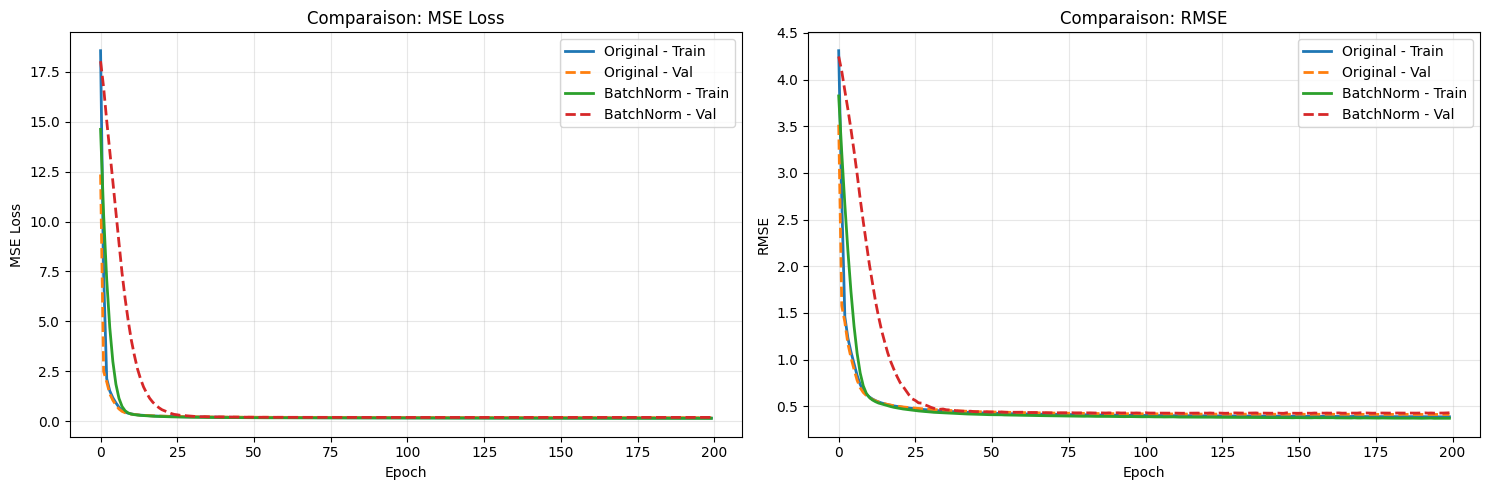

419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step

COMPARAISON DES PERFORMANCES

Métrique             Original        BatchNorm       Amélioration
------------------------------------------------------------
MSE                  0.1639          0.1791          -9.3%
RMSE                 0.4048          0.4232          -4.5%
MAE                  0.2975          0.3125          -5.0%
R² Score             0.6676          0.6368          -3.1%

** Commentaires sur les résultats **
- BatchNormalization devrait converger plus rapidement
- Les courbes devraient être plus lisses
- Val_loss et train_loss plus proches (moins surapprentissage)
- RMSE: 0.4232$ (erreur moyenne sur les prédictions)
- R²: 63.68% (pourcentage de variance expliquée)


In [ ]:
# Compiler le modèle amélioré
model_bn.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Entraîner
print("Entraînement du modèle avec BatchNormalization... (200 epochs)")
history_bn = model_bn.fit(
    X_train, y_train,
    epochs=200,
    batch_size=3000,
    validation_split=0.2,
    verbose=1
)
print("Entraînement terminé!")

# Afficher les courbes de comparaison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbes de loss
axes[0].plot(history.history['loss'], label='Original - Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Original - Val', linewidth=2, linestyle='--')
axes[0].plot(history_bn.history['loss'], label='BatchNorm - Train', linewidth=2)
axes[0].plot(history_bn.history['val_loss'], label='BatchNorm - Val', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Comparaison: MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Courbes de RMSE
axes[1].plot(history.history['root_mean_squared_error'], label='Original - Train', linewidth=2)
axes[1].plot(history.history['val_root_mean_squared_error'], label='Original - Val', linewidth=2, linestyle='--')
axes[1].plot(history_bn.history['root_mean_squared_error'], label='BatchNorm - Train', linewidth=2)
axes[1].plot(history_bn.history['val_root_mean_squared_error'], label='BatchNorm - Val', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparaison: RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prédictions du modèle amélioré
y_pred_bn = model_bn.predict(X_test, verbose=1)
y_pred_bn = y_pred_bn.flatten()

# Calculer les métriques
mse_bn = mean_squared_error(y_test, y_pred_bn)
rmse_bn = np.sqrt(mse_bn)
mae_bn = mean_absolute_error(y_test, y_pred_bn)
r2_bn = r2_score(y_test, y_pred_bn)

# Affichage de la comparaison
print("\n" + "="*60)
print("COMPARAISON DES PERFORMANCES")
print("="*60)
print(f"\n{'Métrique':<20} {'Original':<15} {'BatchNorm':<15} {'Amélioration'}")
print("-"*60)
print(f"{'MSE':<20} {mse:<15.4f} {mse_bn:<15.4f} {(mse-mse_bn)/mse*100:+.1f}%")
print(f"{'RMSE':<20} {rmse:<15.4f} {rmse_bn:<15.4f} {(rmse-rmse_bn)/rmse*100:+.1f}%")
print(f"{'MAE':<20} {mae:<15.4f} {mae_bn:<15.4f} {(mae-mae_bn)/mae*100:+.1f}%")
print(f"{'R² Score':<20} {r2:<15.4f} {r2_bn:<15.4f} {(r2_bn-r2)*100:+.1f}%")

## 3.10 Visualisation des prédictions comparées

Afficher les scatterplots de prédictions pour les deux modèles côte à côte.

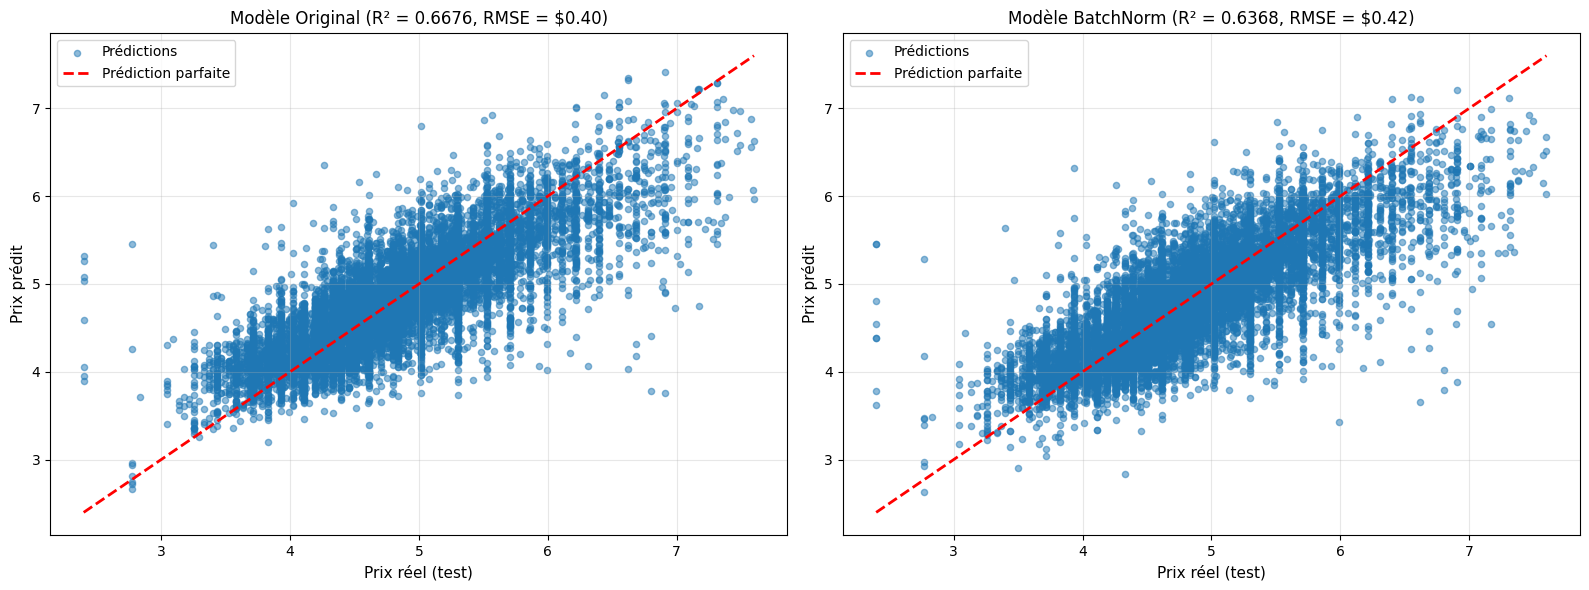

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Modèle original
axes[0].scatter(y_test, y_pred, alpha=0.5, s=20, label='Prédictions')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')
axes[0].set_xlabel('Prix réel (test)', fontsize=11)
axes[0].set_ylabel('Prix prédit', fontsize=11)
axes[0].set_title(f'Modèle Original (R² = {r2:.4f}, RMSE = ${rmse:.2f})', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Modèle avec BatchNormalization
axes[1].scatter(y_test, y_pred_bn, alpha=0.5, s=20, label='Prédictions')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')
axes[1].set_xlabel('Prix réel (test)', fontsize=11)
axes[1].set_ylabel('Prix prédit', fontsize=11)
axes[1].set_title(f'Modèle BatchNorm (R² = {r2_bn:.4f}, RMSE = ${rmse_bn:.2f})', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

### Avantages de BatchNormalization

✓ **Normalise les activations entre les couches** - maintient les distributions d'entrée stables

✓ **Permet des learning rates plus élevés** - convergence plus rapide

✓ **Réduit la sensibilité à l'initialisation des poids** - plus robuste au démarrage

✓ **Agit comme une forme de régularisation** - réduit overfitting

✓ **Améliore généralement la convergence et les performances finales** - meilleur modèle global

### Désavantages

✗ **Augmente le nombre de paramètres** - paramètres gamma et beta supplémentaires

✗ **Comportement différent en train vs test** - utilise des statistiques batch différentes

✗ **Peut ralentir légèrement l'inférence** - étape de normalisation supplémentaire au test